In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

## Summary 

1. Clean infections data: if someone tests negative after testing positive, overwrite that result (assumes these are false negatives)
2. If a patient tests positive within three days of their admission to the facility, we assume they entered with an infection. Clean the data to back-date their start of infection time to admission

In [2]:
epi_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling'

In [3]:
infections = pd.read_csv(f"{epi_dir}/preprocessed/augmented/facility_trace.csv", index_col=0)
infections.columns = np.arange(367)
df_floor = pd.read_csv(f"{epi_dir}/preprocessed/augmented/floor_trace.csv", index_col=0)
df_floor.columns = np.arange(367)
df_room = pd.read_csv(f"{epi_dir}/preprocessed/augmented/room_trace.csv", index_col=0)
df_room.columns = np.arange(367)

In [4]:
infections_cleaned = infections.copy()
messy_indices = []
for i, row in infections_cleaned.iterrows():
    infected = False
    for j, v in row.items():
        if infected:
            if v == 0:
                # does someone test negative after testing positive in a visit?
                # overwrite that test result
                row[j] = 1
                messy_indices.append(i)
        if v == 1:
            infected = True
        if np.isnan(v):
            infected = False
messy_indices = set(messy_indices)

In [5]:
messy_indices

{13, 92, 155, 162, 295}

It's possible that some of these are initial false positives, but we assume these are subsequent false negatives

In [6]:
facility_trace_old= pd.read_csv(f"{epi_dir}/data/2019-12-18_facility_trace.csv", index_col=0)
facility_trace_old.columns = np.arange(367)

In [7]:
never_infected_index = df_floor.index[260:]

In [8]:
# modify this: as long as old ftrace data is available, use that
df_screen = pd.DataFrame(index=df_floor.index, columns=df_floor.columns)
M = facility_trace_old.index.max()
for n, r in facility_trace_old.iterrows():
    entry_time = 0
    entered = False
    recorded = False
    for t, v in r.items():
        if v > 0 and not entered:
            # record entry time
            entry_time = t
            entered = True
        if entered and v == 0:
            # patient has exited facility
            entered = False
            recorded = False
        if v > 1 and not recorded:
            test_time = t - entry_time
            if test_time < 3:
                df_screen.loc[n, entry_time] = 1 if v == 1.5 else 0
                # fix this in infections cleaned?
                infections_cleaned.loc[n, entry_time] = 1 if v == 1.5 else 0
            else:
                df_screen.loc[n,entry_time] = 0
                infections_cleaned.loc[n, entry_time] = 0
            recorded = True

In [9]:
for n in never_infected_index:
    r = infections_cleaned.loc[n]
    entered = False
    for t, v in r.items():
        if not np.isnan(v) and not entered:
            entered = True
            df_screen.loc[n, t] = v
        if entered and np.isnan(v):
            entered = False

In [10]:
df_facility = (infections_cleaned.notna()).astype(int)

## Reconcile floor and room traces



#### Problem 1: phantom visit (floor/room record, no infections record)

Strategy 1: ignore these visits

Strategy 2: fill them in...with ones if they have neighbors, with zeros otherwise (no test records)

strategy 2 is too complicated lol

In [33]:
for n, r in df_facility.iterrows():
    for t, v in r.items():
        
        if (v == 0) and (
            (df_floor.loc[n, t] > 0) or (df_room.loc[n, t] > 0)
        ):
            df_floor.loc[n, t]  = 0
            df_room.loc[n, t] = 0

#### Problem 2: Untraced visit (present but room/floor trace data is unavailable)

strategy: backfill from the last room/floor
unless it's a one-off entry at the beginning of the time series, then assume error

In [48]:
# for n, _ in infections_cleaned.iterrows():
#     if not np.isnan(infections_cleaned.loc[n, 0]) and np.isnan(infections_cleaned.loc[n, 1]):
#         print(n)
#         print(infections_cleaned.loc[n, :5])

In [53]:
df_screen

,0,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
for n, r in df_facility.iterrows():
    for t, v in r.items():
        if (v == 1) and (df_floor.loc[n, t] == 0):
            if t == 0:
                infections_cleaned.loc[n, t] = np.nan
                df_screen.loc[n, t] = np.nan
                df_facility.loc[n, t] = 0
            else:
                df_floor.loc[n, t] = df_floor.loc[n, t-1]
                df_room.loc[n, t] = df_room.loc[n, t-1]

### Sanity Checks

In [69]:
assert ((df_floor > 0).values == (df_room > 0).values).all()
assert ((infections_cleaned.notna()).values == (df_facility > 0).values).all()
for n, r in df_screen.iterrows():
    for t, v in r.items():
        if not np.isnan(v):
            assert infections_cleaned.loc[n, t] == v
            # assert not np.isnan(infections_cleaned.loc[n, t])
assert ((infections_cleaned.notna()).values == (df_floor > 0).values).all()

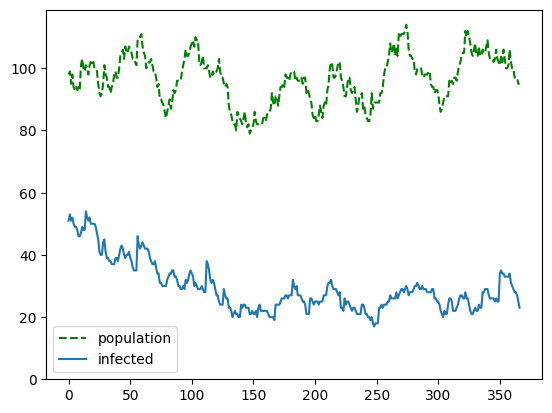

In [70]:
sns.lineplot(df_facility.sum(0), color="green", linestyle="--", label="population")
sns.lineplot(infections_cleaned.sum(0), label="infected")
plt.ylim(bottom=0)
plt.show()

(0.0, 1.0)

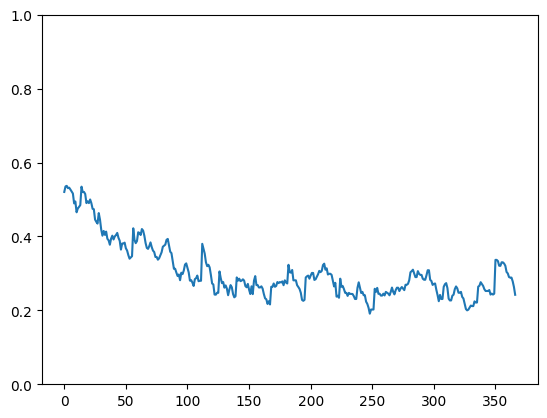

In [71]:
NN = df_facility.sum(0)
II = infections_cleaned.sum(0)

sns.lineplot(II / NN)
plt.ylim(bottom=0, top=1)

### Heterogeneous Observed Data

### Save

In [72]:
# write out data
output_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/preprocessed'
infections_cleaned.to_csv(f"{output_dir}/infections.csv")
# with open(f"{output_dir}/observed_data.npy", "wb") as f:
#     np.save(f, observed_data)
df_screen.to_csv(f"{output_dir}/screening.csv")
df_facility.to_csv(f"{output_dir}/facility_trace.csv")
df_floor.to_csv(f"{output_dir}/floor_trace.csv")
df_room.to_csv(f"{output_dir}/room_trace.csv")